In [1]:
import numpy as np
import pandas as pd
import datetime
import ast

from matplotlib import pyplot as plt

%matplotlib inline

## 1. Problem Statement 

Question > Data Analysis [Cleaning/Basic Analysis of Data]:

- Download the zip file containing customer basic info and event logs
- Files
	- uicycles - contains the install-uninstall events for customers
	- eventdump - contains event triggered within the app for customers

- Info:
	- Customer information contains install-uninstall-reinstall cycles in vertical format [ ~170k records] [so for a customer 1 lifetime cycle is a single install-uninstall event set or a reintall-uninstall event set] [so if a customer install-uninstalls-reinstalls-uninstalls then he has 2 life cycles within the app which need to be treated separately]
	- Event logs contain the events triggered within the app by these customers [ ~1 million records]
- Generate the following from the data provided [Analysis questions below are along the lines of CLTV(Customer Lifetime Value) analysis]
	- Customer retention trends from their lifetime cycles [frequency chart or histogram plot] [retention is defined as the duration of one install-uninstall cycle, so multiple re-installs have to be treated separately]
	- Find out the time of day when the customers are most active [use your own discretion for time of day bucketing] [activity is defined on the basis of events]
	- Purchase value buckets [find purchase/checkout events from event logs and parse the 'properties' column to get total value associated and generate a simple bucketed frequency chart/histogram plot]
	- Behavior of purchasing and non-purchasing customers [something along the lines of their in-app event frequency in a given install-uninstall cycle]
	- Week over Week revenue trends for purchasing customers
		- How are their purchases distributed post install? [the number and value of purchases after installing the app in one retention cycle]
		- Do they perform purchases in the 2nd,3rd etc weeks post install? [if their retention cycle is greater than 1 week]
		- Is there a steady inflow of revenue for customers with high retention? [growth can decline but is it still a positive gradient?]
	- Any other actionable insights that can be drawn from the given data?



## 2. Data Exploration 

### A. Loading the data to pandas dataframes  (data_eventdump and data_uicycles) and checking for the nulls

In [2]:
data_eventdump = pd.read_csv('/Users/deepanjal.gupta/Documents/Uninstall.io/interview/eventdump.csv')
data_uicycles = pd.read_csv('/Users/deepanjal.gupta/Documents/Uninstall.io/interview/uicycles.csv')


print('(data_eventdump.shape) : ' + str(data_eventdump.shape))
print('(data_uicycles.shape)  : ' + str(data_uicycles.shape))

print('')

print('data_eventdump NULLS:')
print(data_eventdump.isnull().sum())
print('')

print('data_uicycles NULLS:')
print(data_uicycles.isnull().sum())
print('')

(data_eventdump.shape) : (995304, 4)
(data_uicycles.shape)  : (161351, 4)

data_eventdump NULLS:
uuid               0
event              0
event_timestamp    0
properties         0
dtype: int64

data_uicycles NULLS:
uuid             2
os               2
event_type       0
creation_date    0
dtype: int64



### B. Checking for the nulls and removing the nulls records 

In [3]:
data_uicycles[data_uicycles['uuid'].isnull()]

,uuid,os,event_type,creation_date
157994,NaN,NaN,install,2016-08-23 14:59:00.0
159756,NaN,NaN,install,2016-08-26 03:59:45.0


In [4]:
#removing the nulls records from data_uicycles
data_uicycles = data_uicycles[data_uicycles['uuid'].notnull()]

print('data_uicycles NULLS:')
print(data_uicycles.isnull().sum())
print('')

data_uicycles NULLS:
uuid             0
os               0
event_type       0
creation_date    0
dtype: int64



### C. Quick view of the two dataframes

In [5]:
print('data_eventdump : ')
data_eventdump.head()

data_eventdump : 


,uuid,event,event_timestamp,properties
0,43e1796c34ac2a91,Cart is viewed,2016-08-29 02:07:56.88,"{""email_id"": ""careers24@gmail.com"", ""timeStamp..."
1,3065bf9960737af,Cart is viewed,2016-08-29 03:04:00.08,"{""email_id"": ""devangnipathak@gmail.com"", ""time..."
2,636677073e9445e3,Search results page viewed,2016-08-29 00:26:23.213,"{""category"": ""Panties"", ""timeStamp"": ""29-08-20..."
3,75f156f9584ffccf,Push notification received,2016-08-29 02:31:20.89,"{""timeStamp"": ""29-08-2016 08:05:40""}"
4,651557edb4a564b0,Search is initiated,2016-08-29 03:12:53.29,"{""search_query"": ""bra for 19 years old "", ""tim..."


In [6]:
print('data_uicycles : ')
data_uicycles.head()

data_uicycles : 


,uuid,os,event_type,creation_date
0,a9ba6d0cd8586a4f,Android,install,2016-08-06 19:54:47.0
1,7365ac7d0721bbf0,Android,re-install,2016-08-14 16:04:45.0
2,4bf1a1368533ad74,Android,uninstall,2016-08-06 17:40:18.0
3,8f2a30a777e2714b,Android,install,2016-08-31 05:25:24.0
4,cd002b38b452db4c,Android,install,2016-08-20 20:19:06.0


### D. Lifetime cycles trends

In [7]:
#here we are assuming that the life cycle starts from re-install/install
#hence we are harmonizing the data making all the 're-install' to 'install'
data_uicycles.loc[data_uicycles['event_type'] == 're-install','event_type'] = 'install'

In [8]:
#here we are generating the ranks in the dataframe which will help in the step after the 
#merge statement where we create the life cycle rows
#rank is generated sorting by ['uuid','creation_date']
cols = ['uuid','creation_date']
tups = data_uicycles.sort_values(cols).apply(tuple,1)
f, i = pd.factorize(tups)
factorized = pd.Series(f + 1, tups.index)

data_uicycles['Rank'] = factorized

In [9]:
#this rank is used in the logic for the merge statement
data_uicycles ['Rank_inter']  = data_uicycles ['Rank'] + 1

In [10]:
data_uicycles.sort_values(by = 'Rank').head()

,uuid,os,event_type,creation_date,Rank,Rank_inter
112941,085d478f5ec1c379,Android,install,2016-08-29 02:31:34.0,1,2
112881,085d478f5ec1c379,Android,uninstall,2016-08-30 05:51:25.0,2,3
15743,10001b8438ddec6,Android,install,2016-08-08 10:36:31.0,3,4
15803,10001b8438ddec6,Android,uninstall,2016-08-09 17:33:51.0,4,5
25087,10007e773c846312,Android,uninstall,2016-08-06 17:40:14.0,5,6


In [11]:
joined = pd.merge(
    data_uicycles, data_uicycles, left_on='Rank',
    right_on='Rank_inter').sort_values('Rank_x')

In [12]:
#this filter_joined dataframe is the list of all the cycles we have derived from our data.
#assumptions only the complete cycles have been considered.
#complete cycles = both install and uninstall is been present
filter_joined = joined[(joined['event_type_x'] == 'uninstall')
                       & (joined['event_type_y'] == 'install') &
                       (joined['uuid_x'] == joined['uuid_y'])]

In [13]:
#cycle_data this contains the time in hrs of each and every completed cycle in our data
cycle_data = pd.to_datetime(filter_joined['creation_date_x']) - pd.to_datetime(filter_joined['creation_date_y'])
cycle_data_hours = (cycle_data.dt.seconds/3600 + cycle_data.dt.days*24)

In [14]:
#each row is one install/uninstall event for a uuid
#multiple rows may exist for a given uuid
cycle_data.head()

112881   1 days 03:19:51
15803    1 days 06:57:20
24495    1 days 01:45:28
141378   1 days 00:46:45
16105    2 days 20:56:39
dtype: timedelta64[ns]

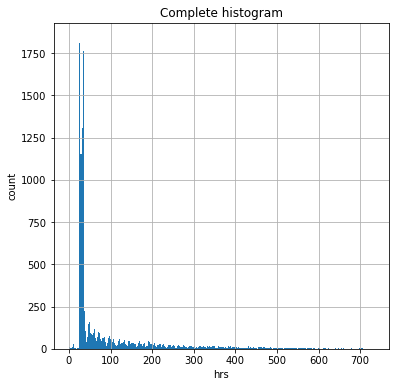

In [15]:
#plotting the complete distribution
cycle_data_hours.hist(bins = 1000,figsize=(6,6))
plt.title('Complete histogram')
plt.xlabel('hrs') 
plt.ylabel('count') 


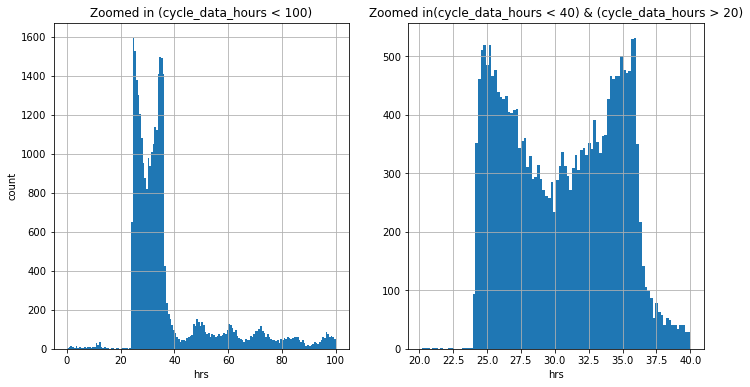

In [16]:
#we can clearly see that there are two peaks of the cycle life @25 hrs and 36 hrs
plt.subplot(1, 3, 1)
cycle_data_hours[(cycle_data_hours < 100)].hist(bins = 160,figsize=(18,6))
plt.title('Zoomed in (cycle_data_hours < 100)')
plt.xlabel('hrs') 
plt.ylabel('count') 

plt.subplot(1, 3, 2)
plt.title('Zoomed in(cycle_data_hours < 40) & (cycle_data_hours > 20)')
cycle_data_hours[(cycle_data_hours < 40) & (cycle_data_hours > 20)].hist(bins = 100)
plt.xlabel('hrs') 

### E.  Customer Activity

In [17]:
#printing the list of all the unique events in the data_eventdump
data_eventdump['event'].unique()

array(['Cart is viewed', 'Search results page viewed',
       'Push notification received', 'Search is initiated',
       'Product is added to cart', 'Sub-Category is viewed',
       'Search icon clicked', 'Category is viewed', 'Login initiated',
       'Product detail is viewed', 'User has logged in',
       'Product is added to wishlist', 'Place Order is initiated',
       'Product review is viewed', 'Login failed', 'Signup is initiated',
       'Add shipping address', 'Product is shared',
       'Search returned 0 results', 'Banner is viewed',
       'Login or signup checkout', 'Pincode Check',
       'Checkout is completed by Cash On Delivery', 'Push Event Clicked',
       'Checkout is completed by Credit Cards / Debit Cards / Net Banking',
       'Shipping addresss added', 'Signup failed',
       'Guest checkout initiated', 'Push notification opened',
       'Checkout is completed by Paid using zCoins', 'Checkout Failed',
       'Brand page is viewed', 'Checkout is completed by PG

In [18]:
#replacing the nulls with 'nulls ' in the 'properties' because it was throwing an error
#when i was trying to convert it to a dict
#for analysis
data_eventdump['properties'] = data_eventdump['properties'].str.replace(' null','"null"')

In [19]:
#getting the list of unique attributes in the properties column
#this step uses a for loop as i did not have an exhaustive list of these attributes beforehand.
#this steps takes the longest as well. :(
final = set()
for i in range(995304):
    a = data_eventdump.loc[i,'properties']
    #print(a)
    b = set(ast.literal_eval(a).keys())
    #data_eventdump[i,'parsed_timestamp'] = (ast.literal_eval(a)['timeStamp'])
    final = final.union(b)

In [20]:
#printing all the unique data that can be presnent in the 'properties'
print(final)

{'email_id', 'search_query', 'Category', 'pincode', 'PINCode Status', 'Login From', 'push_token', 'Sub-Category name', 'Login Type', 'user_login_type', 'status', 'Search String', 'email', 'user_coming_from', 'Product Name', 'clicked_banner_position', 'Brand Name', 'Cart Value', 'cat_name', 'payment_mode', 'shipping', 'discount', 'ns_cart_amount', 'No Of Products', 'category', 'PinCode', 'timeStamp', 'ts', 'PUSH MESSAGE', 'total', 'utm_source', 'SignIn From', 'utm_medium', 'grand_total', 'Search Query', 'categoryname', 'ns_cart_price', 'z_coins', 'pin_code', 'subtotal', 'Product SKU', 'orderId', 'SignIn Type'}


In [21]:
#data_eventdump['parsed_timestamp'] = 'q'
#lister = []
#for i in range(995304):
#
#    a = data_eventdump.loc[i,'properties']
#    #data_eventdump.loc[i,'parsed_timestamp'] = (ast.literal_eval(a).get('timeStamp',np.nan))
#    lister.append((ast.literal_eval(a).get('timeStamp',np.nan)))
#    final = final.union(b)
#
#
#data_eventdump['parsed_timestamp'] = pd.Series(lister)

In [22]:
#for checking when was the used most active,
#we extract the event_timestamp and convert it to time of the day
activiy_time  = pd.to_datetime(data_eventdump['event_timestamp'])

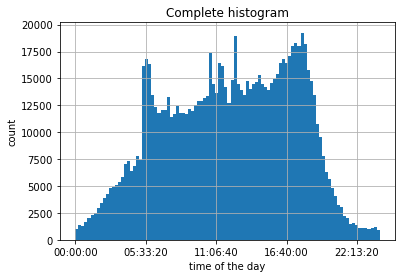

In [23]:
#this will give us an idea of the general distribution of the data over the entire day
activiy_time.dt.time.hist(bins = 100)
plt.title('Complete histogram')
plt.xlabel('time of the day') 
plt.ylabel('count') 


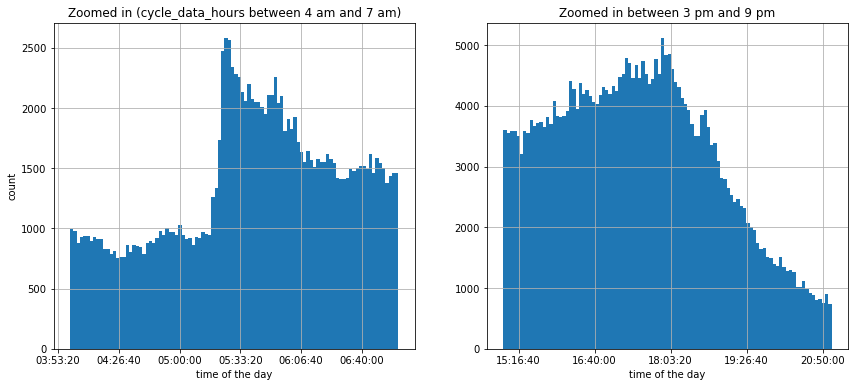

In [24]:
#now let us try to zoom into the two main peaks of the data that we can observe
plt.subplot(1, 3, 1)
activiy_time.dt.time [(activiy_time.dt.time > datetime.time(4, 0, 0)) & (activiy_time.dt.time < datetime.time(7, 0, 0))].hist(bins = 100, figsize = (22,6))
plt.title('Zoomed in (cycle_data_hours between 4 am and 7 am)')
plt.xlabel('time of the day') 
plt.ylabel('count') 

plt.subplot(1, 3, 2)
plt.title('Zoomed in between 3 pm and 9 pm')
activiy_time.dt.time [(activiy_time.dt.time > datetime.time(15, 0, 0)) & (activiy_time.dt.time < datetime.time(21, 0, 0))].hist(bins = 100)
plt.xlabel('time of the day') 

#we can see that there are two peaks : one at around 5:30 am  and one in the evening at 6pm


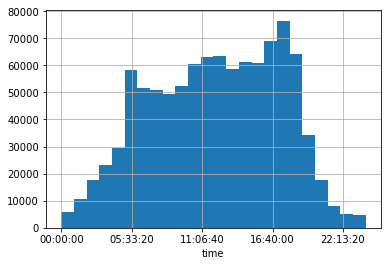

In [25]:
#with hourly bin size = 24
activiy_time.dt.time.hist(bins = 24)

In [26]:
#data_eventdump.groupby('event').size()/data_eventdump.shape[0]*(100)

### F.  Purchase value buckets

In [27]:
#Purchase value buckets [find purchase/checkout events 
#from event logs and parse the 'properties' column to get total value 
#associated and generate a simple bucketed frequency chart/histogram plot]
final

{'Brand Name',
 'Cart Value',
 'Category',
 'Login From',
 'Login Type',
 'No Of Products',
 'PINCode Status',
 'PUSH MESSAGE',
 'PinCode',
 'Product Name',
 'Product SKU',
 'Search Query',
 'Search String',
 'SignIn From',
 'SignIn Type',
 'Sub-Category name',
 'cat_name',
 'category',
 'categoryname',
 'clicked_banner_position',
 'discount',
 'email',
 'email_id',
 'grand_total',
 'ns_cart_amount',
 'ns_cart_price',
 'orderId',
 'payment_mode',
 'pin_code',
 'pincode',
 'push_token',
 'search_query',
 'shipping',
 'status',
 'subtotal',
 'timeStamp',
 'total',
 'ts',
 'user_coming_from',
 'user_login_type',
 'utm_medium',
 'utm_source',
 'z_coins'}

In [28]:
list(data_eventdump['event'].unique())

['Cart is viewed',
 'Search results page viewed',
 'Push notification received',
 'Search is initiated',
 'Product is added to cart',
 'Sub-Category is viewed',
 'Search icon clicked',
 'Category is viewed',
 'Login initiated',
 'Product detail is viewed',
 'User has logged in',
 'Product is added to wishlist',
 'Place Order is initiated',
 'Product review is viewed',
 'Login failed',
 'Signup is initiated',
 'Add shipping address',
 'Product is shared',
 'Search returned 0 results',
 'Banner is viewed',
 'Login or signup checkout',
 'Pincode Check',
 'Checkout is completed by Cash On Delivery',
 'Push Event Clicked',
 'Checkout is completed by Credit Cards / Debit Cards / Net Banking',
 'Shipping addresss added',
 'Signup failed',
 'Guest checkout initiated',
 'Push notification opened',
 'Checkout is completed by Paid using zCoins',
 'Checkout Failed',
 'Brand page is viewed',
 'Checkout is completed by PG',
 'Checkout is completed by null',
 'download_source',
 'uio_push_token',
 'P

In [29]:
#events considered by me for confirming the purchase
events = [
    'Checkout is completed by Cash On Delivery',
    'Checkout is completed by Credit Cards / Debit Cards / Net Banking',
    'Checkout is completed by Paid using zCoins',
    'Checkout is completed by PG', 'Checkout is completed by null'
]

In [30]:
#data_eventdump[data_eventdump['event'].isin(events)]

In [31]:
#this step extracts the attributes of 'No Of Products','total','subtotal' from the 
#'properties' columns

lister_product_no = []
lister_total = []
lister_subtotal = []

for i in range(995304):

    a = data_eventdump.loc[i,'properties']
    #data_eventdump.loc[i,'parsed_timestamp'] = (ast.literal_eval(a).get('timeStamp',np.nan))
    lister_product_no.append((ast.literal_eval(a).get('No Of Products',np.nan)))
    lister_total.append((ast.literal_eval(a).get('total',np.nan)))
    lister_subtotal.append((ast.literal_eval(a).get('subtotal',np.nan)))


In [32]:
print(len(lister_product_no))
print(len(lister_total))
print(len(lister_subtotal))

995304
995304
995304


In [33]:
#we combine the data into a new dataframe for analysis
value_dataframe = pd.DataFrame({'product_no':lister_product_no,'total':lister_total,'subtotal':lister_subtotal})

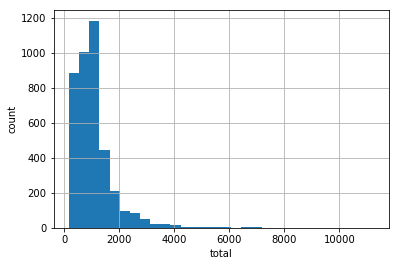

In [34]:
#clearly see that majority of the total cost is clustered around 1000-500
value_dataframe[value_dataframe['total'].notnull()]['total'].hist(bins = 30)
plt.xlabel('total') 
plt.ylabel('count') 

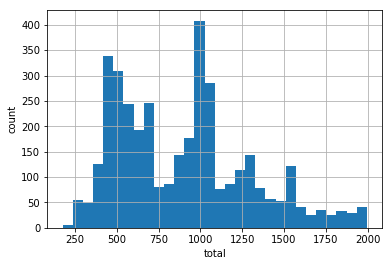

In [35]:
#lets zoom into total less than 2000 for more clarity
#clearly we see two clusters at around 1000 and 5000
value_dataframe[(value_dataframe['total'].notnull())& (value_dataframe['total'] < 2000)]['total'].hist(bins = 30)
plt.xlabel('total') 
plt.ylabel('count') 

### G. Behavior of purchasing and non-purchasing customers

In [36]:
#Behavior of purchasing and non-purchasing customers [something along the lines of 
#their in-app event frequency in a given install-uninstall cycle]

#assuming uuid = customer unique id

In [37]:
#generating the sets with the buying and non buying customers
#note that this distcinction is madee on the 4 events 

    #'Checkout is completed by Cash On Delivery',
    #'Checkout is completed by Credit Cards / Debit Cards / Net Banking',
    #'Checkout is completed by Paid using zCoins',
    #'Checkout is completed by PG', 'Checkout is completed by null'

all_uuid = set(data_eventdump['uuid'].unique())
buyers = set(data_eventdump[data_eventdump['event'].isin(events)]['uuid'].unique())
non_buyers =  all_uuid.difference(buyers)

In [38]:
print(len(all_uuid))
print(len(buyers))
print(len(non_buyers))

72805
3529
69276


In [39]:
#here we group by the uuids for the buyers and non buyers and the number of events they have
event_number_buyers = data_eventdump[data_eventdump['uuid'].isin(buyers)].groupby('uuid').size()
event_number_non_buyers = data_eventdump[data_eventdump['uuid'].isin(non_buyers)].groupby('uuid').size()

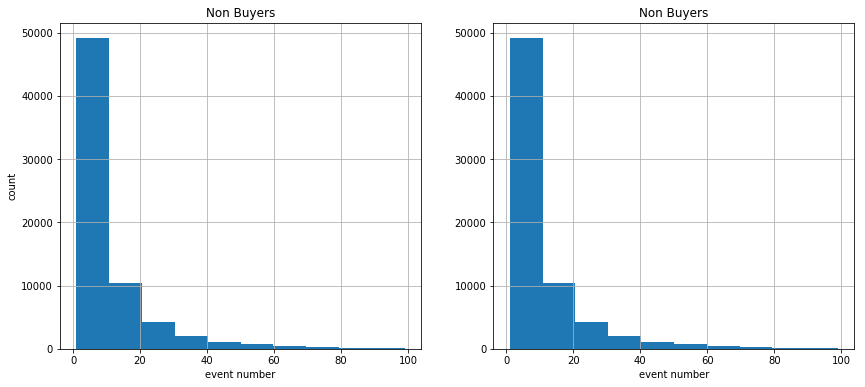

In [40]:
#non buyers first
#non buyers are rarely active on the app
plt.subplot(1, 3, 1)

event_number_non_buyers[event_number_non_buyers< 100].hist(figsize=(22,6))
plt.title('Non Buyers')
plt.xlabel('event number') 
plt.ylabel('count') 

plt.subplot(1, 3, 2)

event_number_non_buyers[event_number_non_buyers< 100].hist(figsize=(22,6))
plt.title('Non Buyers')
plt.xlabel('event number') 

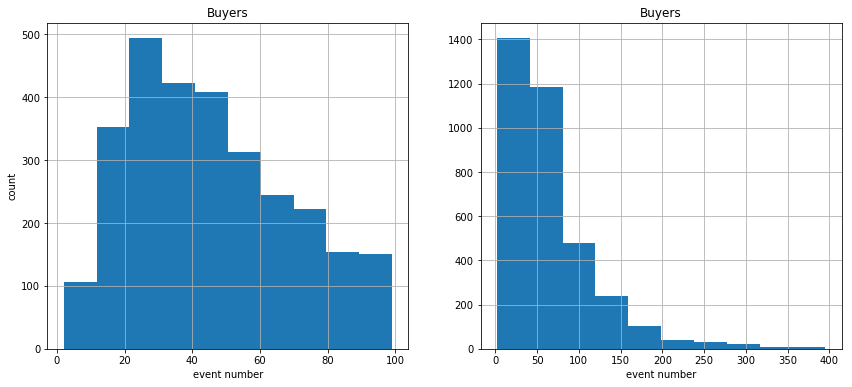

In [41]:
#buyers
#non buyers are more active on the app
#their events is clustered in the high 20s and 30s
plt.subplot(1, 3, 1)

event_number_buyers[event_number_buyers< 100].hist(figsize=(22,6))
plt.title('Buyers')
plt.xlabel('event number') 
plt.ylabel('count') 

plt.subplot(1, 3, 2)

event_number_buyers[event_number_buyers< 400].hist()
plt.title('Buyers')
plt.xlabel('event number') 

### H.  Week over Week revenue trends for purchasing customers

In [42]:
#here we check that in the buyers we have, we only have at max two cycles where purchase has been made
#a = cycle_data.sort_values(by = ['uuid_x','creation_date_y']).groupby(by = 'uuid_x').cumcount() + 1
#a[cycle_data.sort_values(by = ['uuid_x','creation_date_y']).groupby(by = 'uuid_x').cumcount() + 1 > 1]

In [43]:
cycle_data = filter_joined[['uuid_x','event_type_y','creation_date_y','event_type_x','creation_date_x']]

In [44]:
#these are the cycles that satisfy our condition of buying something
cycle_data = cycle_data[cycle_data['uuid_x'].isin(buyers)]
cycle_data.head()

,uuid_x,event_type_y,creation_date_y,event_type_x,creation_date_x
135863,10f3441c28c083db,install,2016-08-26 07:51:51.0,uninstall,2016-08-30 05:51:15.0
151217,117544bfcc491ca7,install,2016-08-28 07:25:28.0,uninstall,2016-08-31 18:42:05.0
145361,11f578925dae72a1,install,2016-08-27 04:01:39.0,uninstall,2016-08-28 18:42:44.0
111181,12f93f4c5dab959e,install,2016-08-11 09:55:10.0,uninstall,2016-08-14 05:43:09.0
160170,134bb8b89b236a93,install,2016-08-27 04:09:02.0,uninstall,2016-08-30 17:59:00.0


In [45]:
#datadump events that we are concerned about
data_eventdump_buy = data_eventdump[(data_eventdump['event'].isin(events))]
data_eventdump_buy.head()

,uuid,event,event_timestamp,properties
351755,43e1796c34ac2a91,Checkout is completed by Cash On Delivery,2016-08-25 16:52:59.113,"{""orderId"": ""600731657"", ""timeStamp"": ""25-08-2..."
351815,a9dda7a3e84389f,Checkout is completed by Cash On Delivery,2016-08-25 20:33:24.527,"{""orderId"": ""600731935"", ""timeStamp"": ""26-08-2..."
351875,24fdb36b8483f66a,Checkout is completed by Cash On Delivery,2016-08-26 03:34:00.457,"{""orderId"": ""600732042"", ""timeStamp"": ""26-08-2..."
351935,1ab1d302727b542f,Checkout is completed by Cash On Delivery,2016-08-26 09:56:59.923,"{""orderId"": ""600732494"", ""timeStamp"": ""26-08-2..."
351995,fd7f809337907ced,Checkout is completed by Cash On Delivery,2016-08-26 09:36:08.44,"{""orderId"": ""600732456"", ""timeStamp"": ""26-08-2..."


In [46]:
cycle_data.sort_values(by= ['uuid_x','creation_date_y'] ).head()

,uuid_x,event_type_y,creation_date_y,event_type_x,creation_date_x
135863,10f3441c28c083db,install,2016-08-26 07:51:51.0,uninstall,2016-08-30 05:51:15.0
151217,117544bfcc491ca7,install,2016-08-28 07:25:28.0,uninstall,2016-08-31 18:42:05.0
145361,11f578925dae72a1,install,2016-08-27 04:01:39.0,uninstall,2016-08-28 18:42:44.0
111181,12f93f4c5dab959e,install,2016-08-11 09:55:10.0,uninstall,2016-08-14 05:43:09.0
160170,134bb8b89b236a93,install,2016-08-27 04:09:02.0,uninstall,2016-08-30 17:59:00.0


In [47]:
# 1 and 2 are for the first and second cycles respectively 
cycle_data_1 = cycle_data[cycle_data.sort_values(by = ['uuid_x','creation_date_y']).groupby(by = 'uuid_x').cumcount() + 1 == 1]
cycle_data_2 = cycle_data[cycle_data.sort_values(by = ['uuid_x','creation_date_y']).groupby(by = 'uuid_x').cumcount() + 1 == 2]

In [48]:
cycle_data_1.head()

,uuid_x,event_type_y,creation_date_y,event_type_x,creation_date_x
135863,10f3441c28c083db,install,2016-08-26 07:51:51.0,uninstall,2016-08-30 05:51:15.0
151217,117544bfcc491ca7,install,2016-08-28 07:25:28.0,uninstall,2016-08-31 18:42:05.0
145361,11f578925dae72a1,install,2016-08-27 04:01:39.0,uninstall,2016-08-28 18:42:44.0
111181,12f93f4c5dab959e,install,2016-08-11 09:55:10.0,uninstall,2016-08-14 05:43:09.0
160170,134bb8b89b236a93,install,2016-08-27 04:09:02.0,uninstall,2016-08-30 17:59:00.0


In [49]:
#here we extract the data from data_eventdump and used join for the first cycle
data_eventdump_buy_1 = data_eventdump_buy.merge(
    cycle_data_1, left_on='uuid', right_on='uuid_x')
data_eventdump_buy_1 = data_eventdump_buy_1[
    (data_eventdump_buy_1['event_timestamp'] >
     data_eventdump_buy_1['creation_date_y']) & (
         (data_eventdump_buy_1['event_timestamp'] <
          data_eventdump_buy_1['creation_date_x']))]

a = {
    'uuid': data_eventdump_buy_1['uuid'],
    'event': data_eventdump_buy_1['event'],
    'event_timestamp': data_eventdump_buy_1['event_timestamp'],
    'properties': data_eventdump_buy_1['properties']
}

data_eventdump_buy_1 = pd.DataFrame(a)

In [50]:
#here we extract the data from data_eventdump and used join for the 2nd cycle
data_eventdump_buy_2 = data_eventdump_buy.merge(
    cycle_data_2, left_on='uuid', right_on='uuid_x')
data_eventdump_buy_2 = data_eventdump_buy_2[
    (data_eventdump_buy_2['event_timestamp'] >
     data_eventdump_buy_2['creation_date_y']) & (
         (data_eventdump_buy_2['event_timestamp'] <
          data_eventdump_buy_2['creation_date_x']))]

a = {
    'uuid': data_eventdump_buy_2['uuid'],
    'event': data_eventdump_buy_2['event'],
    'event_timestamp': data_eventdump_buy_2['event_timestamp'],
    'properties': data_eventdump_buy_2['properties']
}

data_eventdump_buy_2 = pd.DataFrame(a)

In [51]:
#extracting the values from 'properties'
lister_product_no = []
lister_total = []
lister_subtotal = []

for i in data_eventdump_buy_1.index:

    a = data_eventdump_buy_1.loc[i,'properties']
    #data_eventdump.loc[i,'parsed_timestamp'] = (ast.literal_eval(a).get('timeStamp',np.nan))
    lister_product_no.append((ast.literal_eval(a).get('No Of Products',np.nan)))
    lister_total.append((ast.literal_eval(a).get('total',np.nan)))
    lister_subtotal.append((ast.literal_eval(a).get('subtotal',np.nan)))
    
    
value_dataframe_1 = pd.DataFrame({'product_no':lister_product_no,'total':lister_total,'subtotal':lister_subtotal})    

In [52]:
#extracting the values from 'properties'
lister_product_no = []
lister_total = []
lister_subtotal = []

for i in data_eventdump_buy_2.index:

    a = data_eventdump_buy_2.loc[i,'properties']
    #data_eventdump.loc[i,'parsed_timestamp'] = (ast.literal_eval(a).get('timeStamp',np.nan))
    lister_product_no.append((ast.literal_eval(a).get('No Of Products',np.nan)))
    lister_total.append((ast.literal_eval(a).get('total',np.nan)))
    lister_subtotal.append((ast.literal_eval(a).get('subtotal',np.nan)))
    
    
value_dataframe_2 = pd.DataFrame({'product_no':lister_product_no,'total':lister_total,'subtotal':lister_subtotal})    

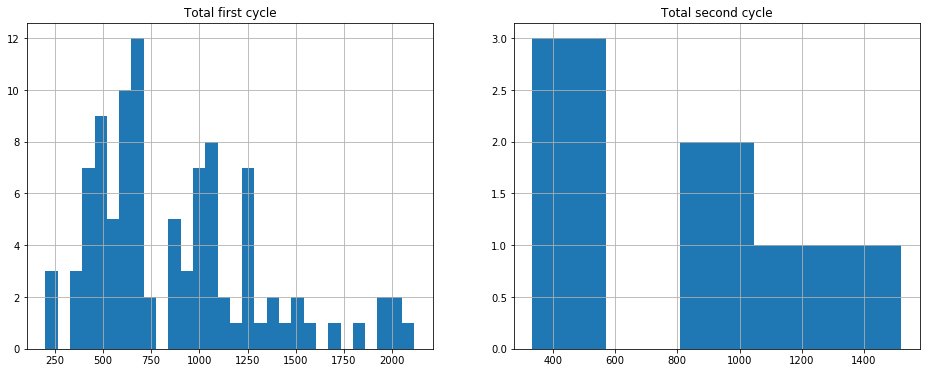

In [53]:
#distrubution of the total is almost the same in both the two cycles,
#hoever the number of purchases is very less in the seconf cycle
plt.subplot(1, 2, 1)
value_dataframe_1['total'].hist(bins = 30,figsize=(16, 6))
plt.title('Total first cycle')
plt.subplot(1, 2, 2)
value_dataframe_2['total'].hist(bins = 5)
plt.title('Total second cycle')

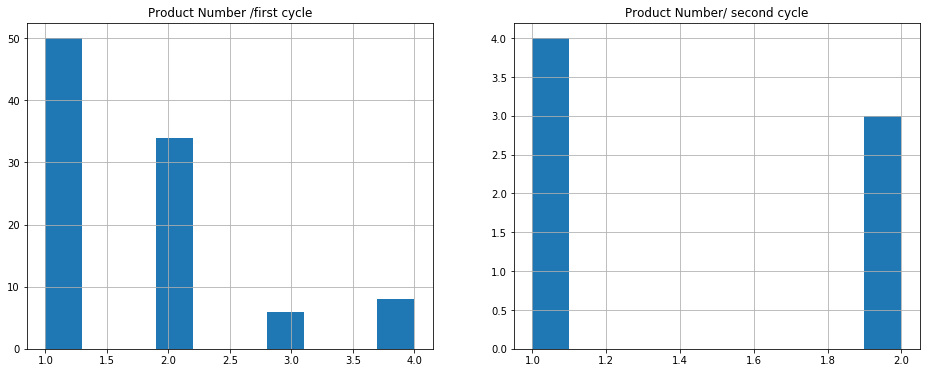

In [54]:
#plot for the number of items pruchased 
plt.subplot(1, 2, 1)
value_dataframe_1['product_no'].hist(figsize=(16, 6))
plt.title('Product Number /first cycle')
plt.subplot(1, 2, 2)
value_dataframe_2['product_no'].hist(figsize=(16, 6))
plt.title('Product Number/ second cycle')